# Introduction

As the healthcare system moves toward value-based care, CMS has created many programs to improve the quality of care of patients. One of these programs is called the Hospital Readmission Reduction Program (HRRP), which reduces reimbursement to hospitals with above average readmissions. For those hospitals which are currently penalized under this program, one solution is to create interventions to provide additional assistance to patients with increased risk of readmission. But how do we identify these patients? We can use predictive modeling from data science to help prioritize patients.

One patient population that is at increased risk of hospitalization and readmission is that of diabetes. Diabetes is a medical condition that affects approximately 1 in 10 patients in the United States. According to Ostling et al, patients with diabetes have almost double the chance of being hospitalized than the general population (Ostling et al 2017). Therefore, in this project, I will focus on predicting hospital readmission for patients with diabetes.

Reference: Ostling, Wyckoff, Ciarkowski, Pai, Choe, Bahl, Gianchandani (2017). “The relationship between diabetes mellitus and 30-day readmission rates” in Clinical Diabetes and Endocrinology. 3:1

# Dataset

The data that is used in this project originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999–2008.

# Project Definition

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

# Data Exploration

In [1]:
# load the csv into a dataframe
import pandas as pd
df = pd.read_csv('diabetic_data.csv')

In [2]:
print('Number of samples:',len(df))

Number of samples: 101766


In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

 If we look at the IDs_mapping.csv we can see that discharge disposition id (where did patient go after hospital) 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model. 

In [6]:
# remove these rows from the file
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [7]:
# create an output label
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

In [8]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

In [9]:
print('prevalence of the positive class: %.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

prevalence of the positive class: 0.114


Around 11% of the population is rehospitalized.

Now we would like to get a feeling of the data for each column in our dataset. Pandas doesn't allow you to see all the columns at once, so let's look at them in groups of 10. 

In [10]:
print('Number of columns:',len(df.columns))

Number of columns: 51


In [11]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


From this, we see that there are a lot of categorical (non-numeric) variables. Note that the variables with _id are also categorical and you can see what the ids refer to with the IDs_mapping.csv. Let's take a look at the unique values for each column. 

In [16]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out, 

    - encounter_id and patient_nbr: these are just identifiers and not useful variables
    - age and weight: are categorical in this data set
    - admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
    - examide and citoglipton only have 1 value, so we will not use these variables
    - diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
    - medical_speciality - has many categorical variables, so we should consider this when making features. 

# Feature Engineering

In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical features, categorical features and extra features. 

In this data set, the missing numbers were filled with a question mark. Let's replace it with a nan representation.

In [17]:
import numpy as np

In [18]:
# replace ? with nan
df = df.replace('?',np.nan)

## Numerical Features

The easiest type of features to use is numerical features. These features do not need any modification. The columns that are numerical that we will use are shown below

In [19]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

Let's check if there are any missing values in the numerical data. 

In [20]:
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical Features

The next type of features we want to create are categorical variables. Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below. 

The first set of categorical data we will deal with are these columns:

In [21]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

Let's check if there are any missing data

In [22]:
df[cols_cat+['medical_specialty']].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
medical_specialty           48616
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the `fillna` function. 

In [23]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin. 

In [24]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                  48616
InternalMedicine                     14237
Emergency/Trauma                      7419
Family/GeneralPractice                7252
Cardiology                            5279
Surgery-General                       3059
Nephrology                            1539
Orthopedics                           1392
Orthopedics-Reconstructive            1230
Radiologist                           1121
Pulmonology                            854
Psychiatry                             853
Urology                                682
ObstetricsandGynecology                669
Surgery-Cardiovascular/Thoracic        642
Gastroenterology                       538
Surgery-Vascular                       525
Surgery-Neuro                          462
PhysicalMedicineandRehabilitation      391
Oncology                               319
Pediatrics                             253
Neurology                              201
Hematology/Oncology                 

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods. 

In [25]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [26]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the `get_dummies` function. I like to use the prefix option so we can trace back to the original column. Compare the outputs from the two dataframes below to verify you understand one-hot encoding. 

In [27]:
df.race.head()

0          Caucasian
1          Caucasian
2    AfricanAmerican
3          Caucasian
4          Caucasian
Name: race, dtype: object

In [28]:
pd.get_dummies(df['race'],prefix = 'race').head()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the `drop_first` option, which will drop the first categorical value. 

In [29]:
pd.get_dummies(df['race'],prefix = 'race', drop_first = True).head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


Now it would be annoying to have to use get_dummies for each categorical column. Luckily, we can send all the columns at once into the get_dummies function and use the column name as the prefix. 

In [30]:
pd.get_dummies(df[cols_cat],drop_first = True).head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


What happens if you send the 3 ID columns into get_dummies?

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [31]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
pd.get_dummies(df[cols_cat_num],drop_first = True).head()

,admission_type_id,discharge_disposition_id,admission_source_id
0,6,25,1
1,1,1,7
2,1,1,7
3,1,1,7
4,1,1,7


You just get the 3 columns back. What happened? The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [32]:
df[cols_cat_num] = df[cols_cat_num].astype('str')

In [33]:
pd.get_dummies(df[cols_cat_num],drop_first = True).head()

,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,...,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Now we are ready to make all of our categorical features

In [34]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [35]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


To add the one-hot encoding columns to the dataframe we can use `concat` function. Make sure to use axis = 1 to indicate add the columns. 

In [36]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data. 

In [37]:
cols_all_cat = list(df_cat.columns)

## Ordinal Features

The last two columns we want to make features are `age` and `weight`. Typically, you would think of these as numerical data, but they are categorical in this dataset as shown below. 

In [38]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


One option could be to create categorical data as shown above. Since there is a natural order to these values, it might make more sense to convert these to numerical data. Another example when you would want to do this might be size of a t-shirt (small, medium, large). Let's start with age. 

In [39]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data. 

In [40]:
age_id = {'[0-10)':0, 
          '[10-20)':1, 
          '[20-30)':2, 
          '[30-40)':3, 
          '[40-50)':4, 
          '[50-60)':5,
          '[60-70)':6, 
          '[70-80)':7, 
          '[80-90)':8, 
          '[90-100)':9}
df['age_group'] = df.age.replace(age_id)

Now let's look at weight. Recall that this feature is not filled out very often.  

In [41]:
df.weight.notnull().sum()

3125

Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value.


In [42]:
df['has_weight'] = df.weight.notnull().astype('int')

In [43]:
cols_extra = ['age_group','has_weight']

## Engineering Features Summary

In [44]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


Let's check if we are missing any data. 

In [45]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

has_weight              0
pioglitazone_No         0
acarbose_No             0
rosiglitazone_Up        0
rosiglitazone_Steady    0
rosiglitazone_No        0
pioglitazone_Up         0
pioglitazone_Steady     0
tolbutamide_Steady      0
acarbose_Up             0
dtype: int64

This looks good. I'll mention later one technique for filling missing data. 

let's make a new dataframe that only has the columns of interest

In [46]:
cols_input = cols_num + cols_all_cat + cols_extra
df_data = df[cols_input + ['OUTPUT_LABEL']]

Double check that the columns used to define your OUTPUT_LABEL are not part of cols_input! 

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    - Training samples: these samples are used to train the model
    - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
    - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model
  
In this tutorial, we will split into 70% train, 15% validation, 15% test. 

The first thing I like to do is to shuffle the samples using `sample` in case there was some order (e.g. all positive samples on top). Here `n` is the number. `random_state` is just specified so the entire class gets the same shuffling. You wouldn't need `random_state` in your own projects. 

In [47]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

We can use sample again to extract 30% (using frac) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it. 

In [48]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction. 

In [49]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that `.drop` just drops the rows from `df_test` to get the rows that were not part of the sample. We can use this same idea to get the training data. 

In [50]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance.

In [51]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


Let's verify that we used all the data.

In [52]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen? 

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:

- sub-sample the more dominant class: use a random subset of the negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data

Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement.


In [53]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


Since we have done a lot of work, let's save our data and start the next part of the tutorial in XYZ.ipynb. Note that `index = False` just drops the index from the csv. 

In [54]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Let's save the cols_input too with a package called `pickle`.

In [55]:
import pickle
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

All machine learning algorithms in sci-kit learn (python package for ML models) cannot handle missing values. Let's create a function to fill in the missing values with the mean. This is a design decision. 

In [56]:
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

Calculate the mean value from the training data. 

In [57]:
df_mean = df_train_all[cols_input].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

In [58]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,time_in_hospital,4.375482
1,num_lab_procedures,42.889071
2,num_procedures,1.330141
3,num_medications,15.971815
4,number_outpatient,0.366365


In [59]:
df_train_all = fill_my_missing(df_train_all, df_mean_in, cols_input)
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [60]:
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler  which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted. 

In [61]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

We will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [62]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [63]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [64]:
# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Model Selection

Wow! so much work to get ready for a model. This is always true in data science. You spend 80-90% cleaning and preparing data. 

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the following functions to evaluate the performance of the model. An explanation of these metrics will be provided at the beginning of week 3. 

In [65]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [66]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 7 machine learning models using default hyperparameters. 

### K nearest neighbors (KNN)

In [67]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [68]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


Our first model did pretty well. We have an AUC of 0.62 that catches 47% of the hospitalizations when we use a threshold of 0.5. Good job. Now it is your turn to do this on your own project! Next week we will talk about a few other predictive model algorithms! 

### Logistic regression

In [69]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [70]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


### Stochastic Gradient Descent

In [71]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.676
accuracy:0.624
recall:0.550
precision:0.646
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.662
accuracy:0.665
recall:0.551
precision:0.179
specificity:0.679
prevalence:0.113
 


### Naive Bayes

In [73]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [74]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


### Decision Tree Classifier

In [75]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [76]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

C:\Users\Andy\AppData\Local\conda\conda\envs\aly_6020\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [78]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.681
accuracy:0.631
recall:0.591
precision:0.642
specificity:0.670
prevalence:0.500
 
Validation:
AUC:0.648
accuracy:0.631
recall:0.577
precision:0.169
specificity:0.638
prevalence:0.113
 


### Gradient Boosting Classifier

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [80]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.638
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


## Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold. 

In [81]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

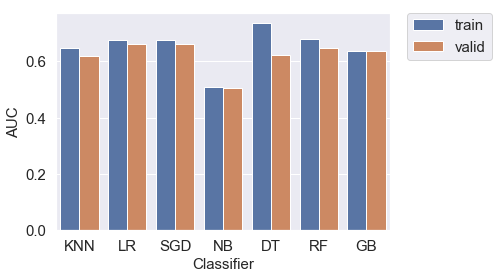

In [83]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

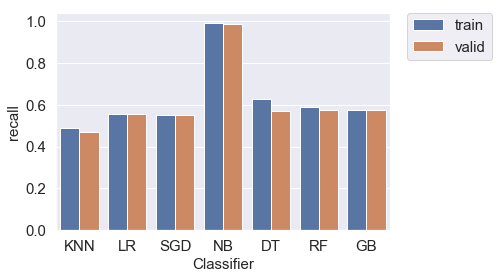

In [84]:
ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

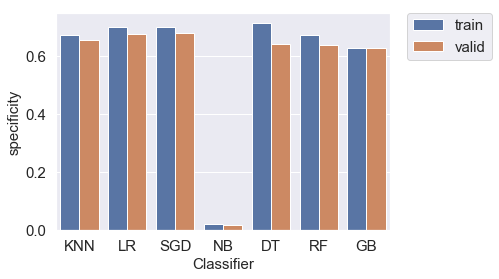

In [85]:
ax = sns.barplot(x="classifier", y="specificity", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('specificity', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

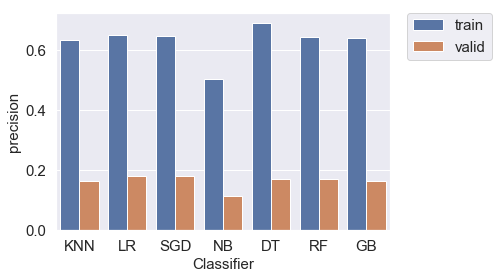

In [86]:
ax = sns.barplot(x="classifier", y="precision", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('precision', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

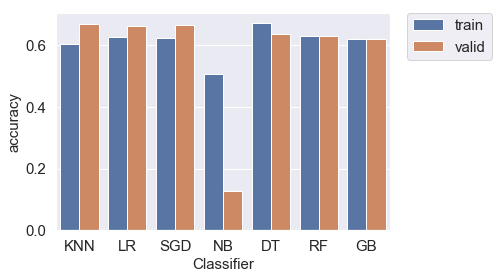

In [87]:
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

# Hyperparameters

In each of these machine learning models, there are hyperparameters which can be tuned to improve the model. These hyperparameters can be thought of as control knobs (such as the volume on your car radio) that you need to adjust for optimal performance. For the discussion board post, you need to explain the concept behind one of the models as well as a hyperparameter. Let's see how we could adjust one hyperparameter below and see its effect. 

Note: this could take a while, so start the code and go work on your presentation. 

In [92]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
import time

# max depths
Ks = np.arange(50,500,50)

# initialize arrays for storing the results
train_aucs = np.zeros(len(Ks))
valid_aucs = np.zeros(len(Ks))

# train a model for each K in a list. Store the auc for the training and validation set
t1 = time.time()
for jj in range(len(Ks)):
    my_K = Ks[jj]
    
    # fit model
    knn=KNeighborsClassifier(n_neighbors = my_K)
    knn.fit(X_train_tf, y_train)
    # get predictions
    y_train_preds = knn.predict_proba(X_train_tf)[:,1]
    y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid
    
    # print the time
    t2 = time.time()
    print(my_K, t2-t1)
    t1 = time.time()

50 132.30429458618164
100 142.29904437065125
150 136.89193677902222
200 137.16703629493713
250 144.02112412452698
300 145.61632418632507
350 146.79454040527344
400 143.96323418617249
450 147.47133421897888


Plot the results

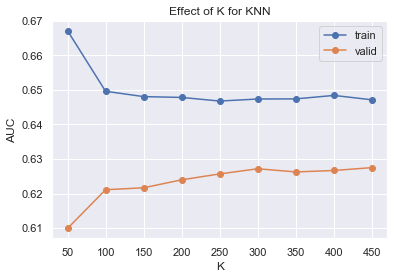

In [93]:
import matplotlib.pyplot as plt

plt.plot(Ks, train_aucs,'o-',label = 'train')
plt.plot(Ks, valid_aucs,'o-',label = 'valid')

plt.xlabel('K')
plt.ylabel('AUC')
plt.title('Effect of K for KNN')
plt.legend()
plt.show()

We can see that as we increase the `max_depth` the training performance is improved. Unfortunately, for this case, the validation performance does not change much. 